# Stable Diffusion -> SVG


## reference
Simple SD -> SVG Iterative opt(https://www.kaggle.com/code/jiazhuang/new-metric-simple-sd-svg-iterative-optimize)

### 主要な流れ
- 画像生成：テキスト説明からビットマップ画像を作成するためにStable Diffusionモデルを利用
- SVG変換：ビットマップ画像を最適化されたSVG形式に変換。ファイルサイズ制限に収まるように最適化
- 評価：生成されたSVGの品質を特有の基準(OCRスコアと美的スコアの積)に従って評価し最適なSVGを選択


```mermaid
    graph LR
    A["テキストプロンプト
    (入力: 説明文)"] --> B("Step 1: Stable Diffusionによる
    ビットマップ画像生成
    (generate_bitmap, Model.gen_bitmap)");
    B --> C("Step 2: ビットマップ画像から
    SVGへの変換と最適化
    (bitmap_to_svg_layered)");
    C --> D("Step 3: 複数試行による
    最適なSVGの選択
    (Model.predict_impl)");
    D --> E["最終的なSVG画像
    (出力)"];
```

In [1]:
#| default_exp core

## 1.準備

### 1.1 初期設定とライブラリのインポート
- 必要なライブラリ（PyTorch、Diffusers、Transformers、OpenCV、Pillowなど）をインポートします。
- Kaggle Hubから、SVG画像の忠実度を評価するための`metric`パッケージをインポートします。https://www.kaggle.com/code/metric/svg-image-fidelity

In [2]:
#| export

import ast
import base64
import io
from io import BytesIO
import math
import os
import random
import re
import statistics
import string
import time
from colorsys import rgb_to_hls, hls_to_rgb
from datetime import timedelta

# --- Third-party Libraries ---
import numpy as np
import pandas as pd

# Image Processing & SVG
import cairosvg
import cv2 # OpenCV 画像処理用
from PIL import Image, ImageFilter # 画像処理用

# Machine Learning & Deep Learning - Core
import torch
import torch.nn as nn
import torch.nn.functional as F

# Machine Learning & Deep Learning - Hugging Face Ecosystem
import clip # OpenAI CLIP
from diffusers import StableDiffusionPipeline, DDIMScheduler # Stable Diffusionモデル用
from transformers import ( # Hugging Face Transformersモデル用
    AutoModel,
    AutoProcessor,
    BitsAndBytesConfig,
    PaliGemmaForConditionalGeneration,
)

# Utilities & Others
import kagglehub
from more_itertools import chunked

# IPython/Jupyter Specific
from IPython.display import SVG # SVG表示用
import matplotlib.pyplot as plt


# --- Project/Competition Specific Imports ---
# Kaggle HubからSVG画像忠実度評価用のメトリックパッケージをインポート
svg_constraints = kagglehub.package_import('metric/svg-constraints')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

### 1.2　ハイパーパラメータ管理 
- `CFG`クラスで、モデルのパス、画像生成パラメータ、SVG変換パラメータ、評価用パラメータなど、ノートブック全体で使用する設定値を一元管理しています。

In [3]:
#| export
# 設定値を管理するクラス
class CFG:
    # デバイス設定
    _PREFERRED_DEVICE_IF_CUDA = "cuda:1"
    device = _PREFERRED_DEVICE_IF_CUDA if torch.cuda.is_available() else "cpu"

    # seed
    random_seed = 30 # 評価時の画像処理初期化
    diffusion_seed = 30 # SD初期化

    use_random_k_means_seed = False # Trueならランダム、Falseならk_means_seedを使用。k_means_seedを使用した場合、毎回同じSVGが生成される
    k_means_seed = 30 # 画像->SVG：初期クラスタの中心点の選択、どのピクセルをどの代表色に割り当てするかの初期化
    
    use_random_decoy_seed = False # Trueならランダム、Falseならdecoy_seed_fixedを使用
    decoy_seed = 30 #　画像->SVG：decoyの位置、サイズの初期化

    # Stable Diffusionモデル設定
    stable_diffusion_model_name = "stabilityai/stable-diffusion-v2/pytorch/1/1" # 使用するモデル名
    sd_torch_dtype = torch.float16 # Stable Diffusionのデータ型（メモリ削減と高速化のため半精度）
    sd_safety_checker = None  # セーフティチェッカーを無効化（速度向上のため）

    model_default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>""" # デフォルトSVG。生成失敗したときに表示される
   
    model_prompt_prefix = "Simple, classic image of" # プロンプト接頭辞
    model_prompt_suffix = "with flat color blocks, beautiful, minimal details, solid colors only" # プロンプト接尾辞
    model_negative_prompt = "lines, framing, hatching, background, textures, patterns, details, outlines" # ネガティブプロンプト
    model_num_inference_steps = 25 # 推論ステップ数。高くすると高品質だが計算に時間がかかる
    model_guidance_scale = 20      # ガイダンススケール。高いと指示通り、低いとクリエイティブ

    # 画像->SVGの変換パラメータ (bitmap_to_svg_layered関数用)
    model_num_attempt = 3      # SVG生成試行回数
    svg_resize = True # SVG変換前にリサイズするかどうか
    svg_target_size = (384, 384) # リサイズする場合のターゲットサイズ
    svg_adaptive_fill = True # SVG生成時に適応的に要素を配置・単純化してスペースを埋めるか
    svg_num_colors_default = 12 # 量子化された後の色数
    svg_contour_min_area = 20 # 無視する輪郭の最小面積の閾値。斑点や細かいガウシアンノイズをフィルタリングするため
    svg_approx_poly_dp_epsilon_factor = 0.02 # 検出された輪郭を単純化（ポリゴン近似）する際の精度を制御。小さくすると元の輪郭と形状が似るが、頂点数が減らない


    # -----------------変更しない。評価で用いられる定数のため-----------------
    svg_max_size_bytes = 10000 # SVGファイルの最大バイト数
    aes_ocr_jpeg_quality = 90 # JPEG圧縮品質
    vqa_aes_harmonic_beta = 0.5 # VQAスコアと美的スコアの調和平均計算時のbeta値

### 1.3 評価指標を計算するヘルパー関数の定義
コンペティションで使用される評価指標を計算するためのヘルパー関数群です。
主に画像（ビットマップやSVGから変換されたPNG）と質問応答データを用いて、
VQAスコア、美的スコア、OCRスコア、そしてそれらを統合した最終スコアを算出します。

### 上から1,2,3番目のコードは変更しない。見る必要ないため非表示推奨。
公式メトリクスを扱いやすくするためのもの

In [4]:
#| export

class VQAEvaluator:
    """Evaluates images based on their similarity to a given text description using multiple choice questions."""

    def __init__(self):
        self.quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type='nf4',
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.float16,
        )
        self.letters = string.ascii_uppercase
        self.model_path = kagglehub.model_download(
            'google/paligemma-2/transformers/paligemma2-10b-mix-448'
        )
        self.processor = AutoProcessor.from_pretrained(self.model_path)
        self.model = PaliGemmaForConditionalGeneration.from_pretrained(
            self.model_path,
            low_cpu_mem_usage=True,
            quantization_config=self.quantization_config,
        ).to('cuda:0')

    def score_yes_no(self, query, image):
        return self.get_yes_probability(image, query)

    def mask_yes_no(self, logits):
        """Masks logits for 'yes' or 'no'."""
        yes_token_id = self.processor.tokenizer.convert_tokens_to_ids('yes')
        no_token_id = self.processor.tokenizer.convert_tokens_to_ids('no')
        yes_with_space_token_id = self.processor.tokenizer.convert_tokens_to_ids(' yes')
        no_with_space_token_id = self.processor.tokenizer.convert_tokens_to_ids(' no')

        mask = torch.full_like(logits, float('-inf'))
        mask[:, yes_token_id] = logits[:, yes_token_id]
        mask[:, no_token_id] = logits[:, no_token_id]
        mask[:, yes_with_space_token_id] = logits[:, yes_with_space_token_id]
        mask[:, no_with_space_token_id] = logits[:, no_with_space_token_id]
        return mask

    def get_yes_probability(self, image, prompt) -> float:
        inputs = self.processor(images=image, text=prompt, return_tensors='pt').to(
            'cuda:0'
        )

        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits[:, -1, :]  # Logits for the last (predicted) token
            masked_logits = self.mask_yes_no(logits)
            probabilities = torch.softmax(masked_logits, dim=-1)

        yes_token_id = self.processor.tokenizer.convert_tokens_to_ids('yes')
        no_token_id = self.processor.tokenizer.convert_tokens_to_ids('no')
        yes_with_space_token_id = self.processor.tokenizer.convert_tokens_to_ids(' yes')
        no_with_space_token_id = self.processor.tokenizer.convert_tokens_to_ids(' no')

        prob_yes = probabilities[0, yes_token_id].item()
        prob_no = probabilities[0, no_token_id].item()
        prob_yes_space = probabilities[0, yes_with_space_token_id].item()
        prob_no_space = probabilities[0, no_with_space_token_id].item()

        total_yes_prob = prob_yes + prob_yes_space
        total_no_prob = prob_no + prob_no_space

        total_prob = total_yes_prob + total_no_prob
        renormalized_yes_prob = total_yes_prob / total_prob

        return renormalized_yes_prob
    
    def score(self, questions, choices, answers, image, n=4):
        scores = []
        batches = (chunked(qs, n) for qs in [questions, choices, answers])
        for question_batch, choice_batch, answer_batch in zip(*batches, strict=True):
            scores.extend(
                self.score_batch(
                    image,
                    question_batch,
                    choice_batch,
                    answer_batch,
                )
            )
        return statistics.mean(scores)

    def score_batch(
        self,
        image: Image.Image,
        questions: list[str],
        choices_list: list[list[str]],
        answers: list[str],
    ) -> list[float]:
        """Evaluates the image based on multiple choice questions and answers in batch.

        Parameters
        ----------
        image : PIL.Image.Image
            The image to evaluate.
        questions : list[str]
            List of questions about the image.
        choices_list : list[list[str]]
            List of lists of possible answer choices, corresponding to each question.
        answers : list[str]
            List of correct answers from the choices, corresponding to each question.

        Returns
        -------
        list[float]
            List of scores (values between 0 and 1) representing the probability of the correct answer for each question, multiplied by OCR score.
        """
        prompts = [
            self.format_prompt(question, choices)
            for question, choices in zip(questions, choices_list, strict=True)
        ]
        batched_choice_probabilities = self.get_choice_probability(
            image, prompts, choices_list
        )

        scores = []
        for i, _ in enumerate(questions):
            choice_probabilities = batched_choice_probabilities[i]
            answer = answers[i]
            answer_probability = 0.0
            for choice, prob in choice_probabilities.items():
                if choice == answer:
                    answer_probability = prob
                    break
            scores.append(answer_probability)

        return scores

    def format_prompt(self, question: str, choices: list[str]) -> str:
        prompt = f'<image>answer en Question: {question}\nChoices:\n'
        for i, choice in enumerate(choices):
            prompt += f'{self.letters[i]}. {choice}\n'
        return prompt

    def mask_choices(self, logits, choices_list):
        """Masks logits for the first token of each choice letter for each question in the batch."""
        batch_size = logits.shape[0]
        masked_logits = torch.full_like(logits, float('-inf'))

        for batch_idx in range(batch_size):
            choices = choices_list[batch_idx]
            for i in range(len(choices)):
                letter_token = self.letters[i]

                first_token = self.processor.tokenizer.encode(
                    letter_token, add_special_tokens=False
                )[0]
                first_token_with_space = self.processor.tokenizer.encode(
                    ' ' + letter_token, add_special_tokens=False
                )[0]

                if isinstance(first_token, int):
                    masked_logits[batch_idx, first_token] = logits[
                        batch_idx, first_token
                    ]
                if isinstance(first_token_with_space, int):
                    masked_logits[batch_idx, first_token_with_space] = logits[
                        batch_idx, first_token_with_space
                    ]

        return masked_logits

    def get_choice_probability(self, image, prompts, choices_list) -> list[dict]:
        inputs = self.processor(
            images=[image] * len(prompts),
            text=prompts,
            return_tensors='pt',
            padding='longest',
        ).to('cuda:0')

        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits[:, -1, :]  # Logits for the last (predicted) token
            masked_logits = self.mask_choices(logits, choices_list)
            probabilities = torch.softmax(masked_logits, dim=-1)

        batched_choice_probabilities = []
        for batch_idx in range(len(prompts)):
            choice_probabilities = {}
            choices = choices_list[batch_idx]
            for i, choice in enumerate(choices):
                letter_token = self.letters[i]
                first_token = self.processor.tokenizer.encode(
                    letter_token, add_special_tokens=False
                )[0]
                first_token_with_space = self.processor.tokenizer.encode(
                    ' ' + letter_token, add_special_tokens=False
                )[0]

                prob = 0.0
                if isinstance(first_token, int):
                    prob += probabilities[batch_idx, first_token].item()
                if isinstance(first_token_with_space, int):
                    prob += probabilities[batch_idx, first_token_with_space].item()
                choice_probabilities[choice] = prob

            # Renormalize probabilities for each question
            total_prob = sum(choice_probabilities.values())
            if total_prob > 0:
                renormalized_probabilities = {
                    choice: prob / total_prob
                    for choice, prob in choice_probabilities.items()
                }
            else:
                renormalized_probabilities = (
                    choice_probabilities  # Avoid division by zero if total_prob is 0
                )
            batched_choice_probabilities.append(renormalized_probabilities)

        return batched_choice_probabilities

    def ocr(self, image, free_chars=4):
        inputs = (
            self.processor(
                text='<image>ocr\n',
                images=image,
                return_tensors='pt',
            )
            .to(torch.float16)
            .to(self.model.device)
        )
        input_len = inputs['input_ids'].shape[-1]

        with torch.inference_mode():
            outputs = self.model.generate(**inputs, max_new_tokens=32, do_sample=False)
            outputs = outputs[0][input_len:]
            decoded = self.processor.decode(outputs, skip_special_tokens=True)

        num_char = len(decoded)

        # Exponentially decreasing towards 0.0 if more than free_chars detected
        return min(1.0, math.exp(-num_char + free_chars))


# make global
vqa_evaluator = VQAEvaluator()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
#| export

class AestheticPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.layers(x)


class AestheticEvaluator:
    def __init__(self):
        # self.model_path = '/kaggle/input/sac-logos-ava1-l14-linearmse/sac+logos+ava1-l14-linearMSE.pth'
        # self.clip_model_path = '/kaggle/input/openai-clip-vit-large-patch14/ViT-L-14.pt'
        self.model_path = os.path.join(
            kagglehub.model_download('jiazhuang/sac-logos-ava1-l14-linearmse/Transformers/default/1'),
            'sac+logos+ava1-l14-linearMSE.pth',
        )
        
        self.clip_model_path = os.path.join(
            kagglehub.model_download('jiazhuang/clip-vit-large-patch14/Transformers/default/1'),
            'ViT-L-14.pt',
        )
        
        self.predictor, self.clip_model, self.preprocessor = self.load()

    def load(self):
        """Loads the aesthetic predictor model and CLIP model."""
        state_dict = torch.load(self.model_path, weights_only=True, map_location='cuda:0')

        # CLIP embedding dim is 768 for CLIP ViT L 14
        predictor = AestheticPredictor(768)
        predictor.load_state_dict(state_dict)
        predictor.to('cuda:0')
        predictor.eval()
        clip_model, preprocessor = clip.load(self.clip_model_path, device='cuda:0')

        return predictor, clip_model, preprocessor


    def score(self, image: Image.Image) -> float:
        """Predicts the CLIP aesthetic score of an image."""
        image = self.preprocessor(image).unsqueeze(0).to('cuda:0')

        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)
            # l2 normalize
            image_features /= image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.cpu().detach().numpy()

        score = self.predictor(torch.from_numpy(image_features).to('cuda:0').float())

        return score.item() / 10.0  # scale to [0, 1]


# make global
aesthetic_evaluator = AestheticEvaluator()

In [6]:
#| export

class ParticipantVisibleError(Exception):
    pass


def score(
    solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, random_seed: int = 0
) -> float:
    """Calculates a fidelity score by comparing generated SVG images to target text descriptions.

    Parameters
    ----------
    solution : pd.DataFrame
        A DataFrame containing target questions, choices, and answers about an SVG image.
    submission : pd.DataFrame
        A DataFrame containing generated SVG strings. Must have a column named 'svg'.
    row_id_column_name : str
        The name of the column containing row identifiers. This column is removed before scoring.
    random_seed : int
        A seed to set the random state.

    Returns
    -------
    float
        The mean fidelity score (a value between 0 and 1) representing the average similarity between the generated SVGs and their descriptions.
        A higher score indicates better fidelity.

    Raises
    ------
    ParticipantVisibleError
        If the 'svg' column in the submission DataFrame is not of string type or if validation of the SVG fails.

    Examples
    --------
    >>> import pandas as pd
    >>> solution = pd.DataFrame({
    ...     'id': ["abcde"],
    ...     'question': ['["Is there a red circle?", "What shape is present?"]'],
    ...     'choices': ['[["yes", "no"], ["square", "circle", "triangle", "hexagon"]]'],
    ...     'answer': ['["yes", "circle"]'],
    ... })
    >>> submission = pd.DataFrame({
    ...     'id': ["abcde"],
    ...     'svg': ['<svg viewBox="0 0 100 100"><circle cx="50" cy="50" r="40" fill="red"/></svg>'],
    ... })
    >>> score(solution, submission, 'row_id', CFG.random_seed)
    0...
    """
    # Convert solution fields to list dtypes and expand
    for colname in ['question', 'choices', 'answer']:
        solution[colname] = solution[colname].apply(ast.literal_eval)
    solution = solution.explode(['question', 'choices', 'answer'])

    # Validate
    if not pd.api.types.is_string_dtype(submission.loc[:, 'svg']):
        raise ParticipantVisibleError('svg must be a string.')

    # Check that SVG code meets defined constraints
    constraints = svg_constraints.SVGConstraints()
    try:
        for svg in submission.loc[:, 'svg']:
            constraints.validate_svg(svg)
    except:
        raise ParticipantVisibleError('SVG code violates constraints.')

    # Score
    # vqa_evaluator = VQAEvaluator()
    # aesthetic_evaluator = AestheticEvaluator()

    results = []
    rng = np.random.RandomState(random_seed)
    try:
        df = solution.merge(submission, on='id')
        for i, (_, group) in enumerate(df.loc[
            :, ['id', 'question', 'choices', 'answer', 'svg']
        ].groupby('id')):
            questions, choices, answers, svg = [
                group[col_name].to_list()
                for col_name in group.drop('id', axis=1).columns
            ]
            svg = svg[0]  # unpack singleton from list
            group_seed = rng.randint(0, np.iinfo(np.int32).max)
            image_processor = ImageProcessor(image=svg_to_png(svg), seed=group_seed).apply()
            image = image_processor.image.copy()
            aesthetic_score = aesthetic_evaluator.score(image)
            vqa_score = vqa_evaluator.score(questions, choices, answers, image)
            image_processor.reset().apply_random_crop_resize().apply_jpeg_compression(quality=90)
            ocr_score = vqa_evaluator.ocr(image_processor.image)
            instance_score = (
                harmonic_mean(vqa_score, aesthetic_score, beta=0.5) * ocr_score
            )
            results.append(instance_score)

    except:
        raise ParticipantVisibleError('SVG failed to score.')

    fidelity = statistics.mean(results)
    return float(fidelity)


def score_instance_impl(multiple_choice_qa, svg, random_seed):
    rng = np.random.RandomState(random_seed)
    group_seed = rng.randint(0, np.iinfo(np.int32).max)
    image_processor = ImageProcessor(image=svg_to_png(svg), seed=group_seed).apply()
    image = image_processor.image.copy()
    questions = multiple_choice_qa['question']
    choices = multiple_choice_qa['choices']
    answers = multiple_choice_qa['answer']
    aesthetic_score = aesthetic_evaluator.score(image)
    vqa_score = vqa_evaluator.score(questions, choices, answers, image)
    image_processor.reset().apply_random_crop_resize().apply_jpeg_compression(quality=90)
    ocr_score = vqa_evaluator.ocr(image_processor.image)
    instance_score = harmonic_mean(vqa_score, aesthetic_score, beta=0.5) * ocr_score
    return instance_score, vqa_score, ocr_score, aesthetic_score

def score_instance(multiple_choice_qa, svg, random_seed):
    is_single = not isinstance(svg, list)
    if is_single:
        multiple_choice_qa = [multiple_choice_qa]
        svg = [svg]
    
    assert len(multiple_choice_qa) == len(svg)

    results = []
    score_df = []
    for one_svg, one_multiple_choice_qa in zip(svg, multiple_choice_qa, strict=True):
        instance_score, vqa_score, ocr_score, aesthetic_score = score_instance_impl(one_multiple_choice_qa, one_svg, CFG.random_seed)
        results.append(instance_score)
        score_df.append([instance_score, vqa_score, ocr_score, aesthetic_score])

    fidelity = statistics.mean(results)
    score_df = pd.DataFrame(score_df, columns=['competition_score', 'vqa_score', 'ocr_score', 'aesthetic_score'])
    if is_single:
        return score_df.iloc[0].to_dict()
    else:
        return float(fidelity), score_df


def harmonic_mean(a: float, b: float, beta: float = 1.0) -> float:
    """
    Calculate the harmonic mean of two values, weighted using a beta parameter.

    Args:
        a: First value (e.g., precision)
        b: Second value (e.g., recall)
        beta: Weighting parameter

    Returns:
        Weighted harmonic mean
    """
    # Handle zero values to prevent division by zero
    if a <= 0 or b <= 0:
        return 0.0
    return (1 + beta**2) * (a * b) / (beta**2 * a + b)


def svg_to_png(svg_code: str, size: tuple = (384, 384)) -> Image.Image:
    """
    Converts an SVG string to a PNG image using CairoSVG.

    If the SVG does not define a `viewBox`, it will add one using the provided size.

    Parameters
    ----------
    svg_code : str
        The SVG string to convert.
    size : tuple[int, int], default=(384, 384)
        The desired size of the output PNG image (width, height).

    Returns
    -------
    PIL.Image.Image
        The generated PNG image.
    """
    # Ensure SVG has proper size attributes
    if 'viewBox' not in svg_code:
        svg_code = svg_code.replace('<svg', f'<svg viewBox="0 0 {size[0]} {size[1]}"')

    # Convert SVG to PNG
    png_data = cairosvg.svg2png(bytestring=svg_code.encode('utf-8'))
    return Image.open(io.BytesIO(png_data)).convert('RGB').resize(size)


class ImageProcessor:
    def __init__(self, image: Image.Image, seed=None):
        """Initialize with either a path to an image or a PIL Image object."""
        self.image = image
        self.original_image = self.image.copy()
        if seed is not None:
            self.rng = np.random.RandomState(seed)
        else:
            self.rng = np.random

    def reset(self):
        self.image = self.original_image.copy()
        return self

    def visualize_comparison(
        self,
        original_name='Original',
        processed_name='Processed',
        figsize=(10, 5),
        show=True,
    ):
        """Display original and processed images side by side."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        ax1.imshow(np.asarray(self.original_image))
        ax1.set_title(original_name)
        ax1.axis('off')

        ax2.imshow(np.asarray(self.image))
        ax2.set_title(processed_name)
        ax2.axis('off')

        title = f'{original_name} vs {processed_name}'
        fig.suptitle(title)
        fig.tight_layout()
        if show:
            plt.show()
        return fig

    def apply_median_filter(self, size=3):
        """Apply median filter to remove outlier pixel values.

        Args:
            size: Size of the median filter window.
        """
        self.image = self.image.filter(ImageFilter.MedianFilter(size=size))
        return self

    def apply_bilateral_filter(self, d=9, sigma_color=75, sigma_space=75):
        """Apply bilateral filter to smooth while preserving edges.

        Args:
            d: Diameter of each pixel neighborhood
            sigma_color: Filter sigma in the color space
            sigma_space: Filter sigma in the coordinate space
        """
        # Convert PIL Image to numpy array for OpenCV
        img_array = np.asarray(self.image)

        # Apply bilateral filter
        filtered = cv2.bilateralFilter(img_array, d, sigma_color, sigma_space)

        # Convert back to PIL Image
        self.image = Image.fromarray(filtered)
        return self

    def apply_fft_low_pass(self, cutoff_frequency=0.5):
        """Apply low-pass filter in the frequency domain using FFT.

        Args:
            cutoff_frequency: Normalized cutoff frequency (0-1).
                Lower values remove more high frequencies.
        """
        # Convert to numpy array, ensuring float32 for FFT
        img_array = np.array(self.image, dtype=np.float32)

        # Process each color channel separately
        result = np.zeros_like(img_array)
        for i in range(3):  # For RGB channels
            # Apply FFT
            f = np.fft.fft2(img_array[:, :, i])
            fshift = np.fft.fftshift(f)

            # Create a low-pass filter mask
            rows, cols = img_array[:, :, i].shape
            crow, ccol = rows // 2, cols // 2
            mask = np.zeros((rows, cols), np.float32)
            r = int(min(crow, ccol) * cutoff_frequency)
            center = [crow, ccol]
            x, y = np.ogrid[:rows, :cols]
            mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r * r
            mask[mask_area] = 1

            # Apply mask and inverse FFT
            fshift_filtered = fshift * mask
            f_ishift = np.fft.ifftshift(fshift_filtered)
            img_back = np.fft.ifft2(f_ishift)
            img_back = np.real(img_back)

            result[:, :, i] = img_back

        # Clip to 0-255 range and convert to uint8 after processing all channels
        result = np.clip(result, 0, 255).astype(np.uint8)

        # Convert back to PIL Image
        self.image = Image.fromarray(result)
        return self

    def apply_jpeg_compression(self, quality=85):
        """Apply JPEG compression.

        Args:
            quality: JPEG quality (0-95). Lower values increase compression.
        """
        buffer = io.BytesIO()
        self.image.save(buffer, format='JPEG', quality=quality)
        buffer.seek(0)
        self.image = Image.open(buffer)
        return self

    def apply_random_crop_resize(self, crop_percent=0.05):
        """Randomly crop and resize back to original dimensions.

        Args:
            crop_percent: Percentage of image to crop (0-0.4).
        """
        width, height = self.image.size
        crop_pixels_w = int(width * crop_percent)
        crop_pixels_h = int(height * crop_percent)

        left = self.rng.randint(0, crop_pixels_w + 1)
        top = self.rng.randint(0, crop_pixels_h + 1)
        right = width - self.rng.randint(0, crop_pixels_w + 1)
        bottom = height - self.rng.randint(0, crop_pixels_h + 1)

        self.image = self.image.crop((left, top, right, bottom))
        self.image = self.image.resize((width, height), Image.BILINEAR)
        return self

    def apply(self):
        """Apply an ensemble of defenses."""
        return (
            self.apply_random_crop_resize(crop_percent=0.03)
            .apply_jpeg_compression(quality=95)
            .apply_median_filter(size=9)
            .apply_fft_low_pass(cutoff_frequency=0.5)
            .apply_bilateral_filter(d=5, sigma_color=75, sigma_space=75)
            .apply_jpeg_compression(quality=92)
        )

In [7]:
# 指定されたサイズに画像をリサイズする関数
def image_resize(image, size=(384, 384)): # 注意: target_sizeは一貫性があればCFGからも取得可能
    return image.convert('RGB').resize(size)

# ビットマップ画像のスコア（インスタンス単位）を計算する内部実装関数
# VQAスコア、美的スコア、OCRスコア、およびそれらを統合したコンペティションスコアを返す
def bitmap_score_instance_impl(multiple_choice_qa, image, random_seed=CFG.random_seed):
    rng = np.random.RandomState(random_seed) # 指定されたシードで乱数生成器を初期化
    group_seed = rng.randint(0, np.iinfo(np.int32).max) # 評価用シードを生成
    
    # 画像処理（リサイズ）
    image_processor = ImageProcessor(image=image_resize(image), seed=group_seed).apply()
    processed_image = image_processor.image.copy() # 処理済み画像を取得
    
    # QAデータ取得
    questions = multiple_choice_qa['question']
    choices = multiple_choice_qa['choices']
    answers = multiple_choice_qa['answer']
    
    # 各スコアの計算
    aesthetic_score = aesthetic_evaluator.score(processed_image) # 美的スコア
    vqa_score = vqa_evaluator.score(questions, choices, answers, processed_image) # VQAスコア
    
    # OCRスコア計算用の画像処理（ランダムクロップ・リサイズ、JPEG圧縮）
    image_processor.reset().apply_random_crop_resize().apply_jpeg_compression(quality=CFG.aes_ocr_jpeg_quality) # qualityはCFGから取得
    ocr_score = vqa_evaluator.ocr(image_processor.image) # OCRスコア
    
    # 最終的なインスタンススコアの計算 (VQAと美的スコアの調和平均にOCRスコアを乗算)
    instance_score = harmonic_mean(vqa_score, aesthetic_score, beta=CFG.vqa_aes_harmonic_beta) * ocr_score
    
    return instance_score, vqa_score, ocr_score, aesthetic_score

# ビットマップ画像のスコアを計算する関数 (単一または複数の画像に対応)
def bitmap_score_instance(multiple_choice_qa, image, random_seed=CFG.random_seed):
    is_single = not isinstance(image, list) # 入力が単一画像かどうかを判定
    if is_single:
        # 単一画像の場合、リストに変換して統一的に処理
        multiple_choice_qa = [multiple_choice_qa]
        image = [image]

    assert len(multiple_choice_qa) == len(image), "QAデータと画像の数が一致しません"

    results = []
    score_df_rows = []
    for one_image, one_multiple_choice_qa in zip(image, multiple_choice_qa, strict=True):
        # 各画像に対してスコア計算
        instance_score, vqa_score, ocr_score, aesthetic_score = bitmap_score_instance_impl(
            one_multiple_choice_qa, one_image, random_seed=random_seed # random_seedを渡す
        )
        results.append(instance_score)
        score_df_rows.append([instance_score, vqa_score, ocr_score, aesthetic_score])

    fidelity = statistics.mean(results) if results else 0.0 # 平均スコアを計算
    score_df = pd.DataFrame(score_df_rows, columns=['competition_score', 'vqa_score', 'ocr_score', 'aesthetic_score'])
    
    if is_single:
        # 単一画像の場合は辞書形式でスコアを返す
        return score_df.iloc[0].to_dict()
    else:
        # 複数画像の場合は平均スコアと詳細スコアのDataFrameを返す
        return float(fidelity), score_df

In [8]:
#| export
# 生成されたSVGの中からどれを選ぶのかのアルゴリズムが書かれている
# SVGコンテンツから美的スコアとOCRスコアを取得する関数

def get_aes_and_ocr_score(svg_content_str):
    """
    SVG文字列から美的スコアとOCRスコアを計算します。
    Args:
        svg_content_str (str): SVG形式の文字列。
    Returns:
        tuple: (美的スコア, OCRスコア)。
    """
    # SVGをPNGに変換し、画像処理を実行
    pil_image = svg_to_png(svg_content_str)

    # seedの取得方法を公式メトリックと同じにする
    rng_for_aes = np.random.RandomState(CFG.random_seed)
    seed_for_image_processor = rng_for_aes.randint(0, np.iinfo(np.int32).max)

    image_proc_for_aes = ImageProcessor(image=pil_image.copy(), seed=seed_for_image_processor).apply()
    processed_img_for_aes = image_proc_for_aes.image.copy() # apply() 後の画像を取得
    
    aesthetic_val = aesthetic_evaluator.score(processed_img_for_aes) # 美的スコア計算
    
    # OCRスコア計算用の画像処理 (ランダムクロップ・リサイズ、JPEG圧縮。品質はCFGから取得)
    image_proc_for_aes.reset().apply_random_crop_resize().apply_jpeg_compression(quality=CFG.aes_ocr_jpeg_quality)
    ocr_val = vqa_evaluator.ocr(image_proc_for_aes.image) # OCRスコア計算
    
    return aesthetic_val, ocr_val

In [9]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from IPython.display import HTML, display # Jupyter Notebook/Labでの表示用
# import warnings

# # --- スコア計算関数 (範囲 [0, 1]) ---
# def harmonic_mean(a: float, b: float, beta: float = 0.5) -> float:
#     if a <= 0 or b <= 0:
#         return 0.0
#     numerator = (1 + beta**2) * a * b
#     denominator = (beta**2 * a) + b
#     if denominator <= 0:
#         return 0.0
#     return numerator / denominator

# def calculate_instance_score(vqa_score: float, aesthetic_score: float, ocr_score: float, beta: float = 0.5) -> float:
#     vqa_score = np.clip(vqa_score, 0, 1)
#     aesthetic_score = np.clip(aesthetic_score, 0, 1)
#     ocr_score = np.clip(ocr_score, 0, 1)
#     hm = harmonic_mean(vqa_score, aesthetic_score, beta=beta)
#     instance_score = hm * ocr_score
#     return instance_score

# # --- アニメーション設定 ---
# num_animation_frames = 60
# vqa_anim_values = np.linspace(0.01, 1.0, num_animation_frames)
# beta_val = 0.5
# num_grid_points = 50 # 勾配計算のため少し解像度を上げる
# score_max_range = 1.0

# # --- グリッドデータの準備 ---
# aes_min, aes_max = 0.01, score_max_range
# ocr_min, ocr_max = 0.01, score_max_range
# aes_vals = np.linspace(aes_min, aes_max, num_grid_points)
# ocr_vals = np.linspace(ocr_min, ocr_max, num_grid_points)
# AES, OCR = np.meshgrid(aes_vals, ocr_vals)

# # --- インスタンススコアの最大値 ---
# plot_vmax = 1.0

# # --- アニメーション描画の準備 ---
# fig, ax = plt.subplots(figsize=(8, 7))

# # 最初のフレームのデータ計算
# InstanceScore_grid_initial = np.zeros_like(AES)
# for r_idx in range(AES.shape[0]):
#     for c_idx in range(AES.shape[1]):
#         InstanceScore_grid_initial[r_idx, c_idx] = calculate_instance_score(
#             vqa_anim_values[0], AES[r_idx, c_idx], OCR[r_idx, c_idx], beta=beta_val
#         )

# # imshowで初期ヒートマップを描画
# im = ax.imshow(InstanceScore_grid_initial, cmap='viridis', origin='lower',
#                extent=[aes_min, aes_max, ocr_min, ocr_max],
#                aspect='auto', vmin=0, vmax=plot_vmax, alpha=0.8)

# # 等高線レベルの設定
# contour_levels = np.arange(0.05, 1.0, 0.1)

# # 初期等高線の描画
# contour_lines = ax.contour(AES, OCR, InstanceScore_grid_initial, levels=contour_levels, colors='white', linewidths=0.7)
# if contour_lines.collections:
#     contour_labels = ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')
# else:
#     contour_labels = []

# # 対角線の追加
# diag_line, = ax.plot([aes_min, aes_max], [ocr_min, ocr_max], color='grey', linestyle='--', linewidth=1.0, label='Aesthetic = OCR') # 少し目立たない色に

# # *** 勾配最大点の初期プロット ***
# # 勾配計算
# grad_ocr, grad_aes = np.gradient(InstanceScore_grid_initial, ocr_vals, aes_vals) # 軸のスケールも考慮
# gradient_magnitude = np.sqrt(grad_aes**2 + grad_ocr**2)
# # 最大点のインデックス取得
# max_grad_idx_flat = np.argmax(gradient_magnitude)
# max_grad_idx_r, max_grad_idx_c = np.unravel_index(max_grad_idx_flat, gradient_magnitude.shape)
# # 最大点の座標
# max_grad_aes = AES[max_grad_idx_r, max_grad_idx_c]
# max_grad_ocr = OCR[max_grad_idx_r, max_grad_idx_c]
# # マーカープロット (オブジェクトを保持)
# max_grad_marker, = ax.plot(max_grad_aes, max_grad_ocr, 'ro', markersize=8, label='Max Gradient Magnitude')

# # 軸ラベルと初期タイトル
# ax.set_xlabel('Aesthetic Score (0-1)')
# ax.set_ylabel('OCR Score (0-1)')
# title = ax.set_title(f'VQA Score = {vqa_anim_values[0]:.3f}')

# # カラーバーを追加
# cbar = fig.colorbar(im, label='Instance Score')
# # 凡例（対角線とマーカー用）
# ax.legend(handles=[diag_line, max_grad_marker], loc='lower right')


# # --- アニメーション更新関数 ---
# previous_contour_lines = contour_lines
# previous_contour_labels = contour_labels
# # マーカーオブジェクトはグローバル変数 max_grad_marker で保持

# def update_frame(vqa_value):
#     global previous_contour_lines, previous_contour_labels, max_grad_marker

#     # インスタンススコアのグリッドを再計算
#     InstanceScore_grid = np.zeros_like(AES)
#     for r_idx in range(AES.shape[0]):
#         for c_idx in range(AES.shape[1]):
#             InstanceScore_grid[r_idx, c_idx] = calculate_instance_score(
#                 vqa_value, AES[r_idx, c_idx], OCR[r_idx, c_idx], beta=beta_val
#             )

#     # imshowデータ更新
#     im.set_data(InstanceScore_grid)
#     # タイトル更新
#     title.set_text(f'VQA Score = {vqa_value:.3f}')

#     # 等高線の更新
#     if previous_contour_lines:
#         for collection in previous_contour_lines.collections:
#             try: collection.remove()
#             except ValueError: pass
#     if previous_contour_labels:
#         for text_label in previous_contour_labels:
#             try: text_label.remove()
#             except ValueError: pass

#     new_contour_lines = ax.contour(AES, OCR, InstanceScore_grid, levels=contour_levels, colors='white', linewidths=0.7)
#     if new_contour_lines.collections:
#         new_contour_labels = ax.clabel(new_contour_lines, inline=True, fontsize=8, fmt='%.2f')
#     else:
#         new_contour_labels = []
#     previous_contour_lines = new_contour_lines
#     previous_contour_labels = new_contour_labels

#     # *** 勾配最大点の更新 ***
#     # 勾配計算
#     grad_ocr, grad_aes = np.gradient(InstanceScore_grid, ocr_vals, aes_vals)
#     gradient_magnitude = np.sqrt(grad_aes**2 + grad_ocr**2)
#     # 最大点のインデックス取得
#     max_grad_idx_flat = np.argmax(gradient_magnitude)
#     max_grad_idx_r, max_grad_idx_c = np.unravel_index(max_grad_idx_flat, gradient_magnitude.shape)
#     # 最大点の座標
#     max_grad_aes = AES[max_grad_idx_r, max_grad_idx_c]
#     max_grad_ocr = OCR[max_grad_idx_r, max_grad_idx_c]
#     # マーカーの位置を更新 (前のマーカーは消さずに位置だけ変える)
#     max_grad_marker.set_data(max_grad_aes, max_grad_ocr)

#     # 対角線は静的

#     # blit=False なので返り値は空でよい
#     return []

# # --- アニメーションオブジェクトの生成 ---
# ani = animation.FuncAnimation(fig, update_frame, frames=vqa_anim_values,
#                               interval=100, blit=False, repeat_delay=1000)

# # --- アニメーションの表示 ---
# plt.close(fig)
# display(HTML(ani.to_jshtml()))

# # --- アニメーションをファイルに保存する場合 (オプション) ---
# # print("アニメーションをGIFファイルに保存中...")
# # ani.save('instance_score_animation_max_gradient.gif', writer='pillow', fps=10)
# # print("保存完了: instance_score_animation_max_gradient.gif")

### 1.4.OCR対策のヘルパー関数
画像内に意図的に文字と認識されるオブジェクトを設置する関数を定義

うまくいけば、評価モデルが1文字としてカウントされることが期待される。
視覚的な影響を最小限に抑えるために、2番目に暗い色と2番目に明るい色を使用している。

In [10]:
#| export
def add_ocr_decoy_svg(svg_code: str) -> str:
    """
    既存のSVGから2番目に暗い色と2番目に明るい色を使って入れ子になった円を追加します。
    円は四隅のいずれかにランダムに配置されますが、画像処理中にクロップされないように位置が調整されます。

    引数:
    -----------
    svg_code : str
        元のSVG文字列
    decoy_seed : int
        ランダムジェネレータを初期化するためのシード値

    戻り値:
    --------
    str
        入れ子になった円が追加された、変更後のSVG文字列
    """

    # seed設定
    if CFG.use_random_decoy_seed:
        decoy_seed = random.randint(0, 2**32 - 1)
    else:
        decoy_seed = random.Random(CFG.decoy_seed)

    rng = random.Random(decoy_seed)
    
    # SVGに閉じタグがあるか確認
    if "</svg>" not in svg_code:
        return svg_code
    
    # viewBoxが存在すれば抽出して寸法を把握
    viewbox_match = re.search(r'viewBox=["\'](.*?)["\']', svg_code)
    if viewbox_match:
        viewbox = viewbox_match.group(1).split()
        try:
            x, y, width, height = map(float, viewbox)
        except ValueError:
            # viewBoxを解析できない場合のデフォルト寸法
            width, height = 384, 384
    else:
        # viewBoxが見つからない場合のデフォルト寸法
        width, height = 384, 384
    
    # 16進数カラーコードをRGBに変換する関数
    def hex_to_rgb(hex_color):
        hex_color = hex_color.lstrip('#')
        if len(hex_color) == 3:
            hex_color = ''.join([c*2 for c in hex_color])
        return tuple(int(hex_color[i:i+2], 16)/255 for i in (0, 2, 4))
    
    # RGBを16進数カラーコードに変換する関数
    def rgb_to_hex(rgb):
        return '#{:02x}{:02x}{:02x}'.format(
            int(rgb[0] * 255), 
            int(rgb[1] * 255), 
            int(rgb[2] * 255)
        )
    
    # 色の明度を計算する関数
    def get_lightness(color):
        # さまざまなカラーフォーマットに対応
        if color.startswith('#'):
            rgb = hex_to_rgb(color)
            return rgb_to_hls(*rgb)[1]  # 明度はHLSの2番目の値
        elif color.startswith('rgb'):
            rgb_match = re.search(r'rgb\((\d+),\s*(\d+),\s*(\d+)\)', color)
            if rgb_match:
                r, g, b = map(lambda x: int(x)/255, rgb_match.groups())
                return rgb_to_hls(r, g, b)[1]
        return 0.5  # 解析できない場合のデフォルト明度
    
    # SVGからすべての色を抽出
    color_matches = re.findall(r'(?:fill|stroke)="(#[0-9A-Fa-f]{3,6}|rgb\(\d+,\s*\d+,\s*\d+\))"', svg_code)
    
    # 十分な色が見つからない場合のデフォルト色
    second_darkest_color = "#333333"  # デフォルトはダークグレー
    second_brightest_color = "#CCCCCC"  # デフォルトはライトグレー
    
    if color_matches:
        # 重複を削除してユニークな色を取得
        unique_colors = list(set(color_matches))
        
        # 各ユニークな色の明度を計算
        colors_with_lightness = [(color, get_lightness(color)) for color in unique_colors]
        
        # 明度（明るさ）でソート
        sorted_colors = sorted(colors_with_lightness, key=lambda x: x[1])
        
        # ユニークな色の数に基づいて異なるシナリオを処理
        if len(sorted_colors) >= 4:
            # 少なくとも4つのユニークな色がある場合 - 2番目に暗い色と2番目に明るい色を使用
            second_darkest_color = sorted_colors[1][0]
            second_brightest_color = sorted_colors[-2][0]
        elif len(sorted_colors) == 3:
            # 3つのユニークな色がある場合 - 2番目に暗い色と最も明るい色を使用
            second_darkest_color = sorted_colors[1][0]
            second_brightest_color = sorted_colors[2][0]
        elif len(sorted_colors) == 2:
            # 2つのユニークな色しかない場合 - 最も暗い色と最も明るい色を使用
            second_darkest_color = sorted_colors[0][0]
            second_brightest_color = sorted_colors[1][0]
        elif len(sorted_colors) == 1:
            # 1色しかない場合 - それを2番目に暗い色として使用し、派生した明るいバージョンを生成
            base_color = sorted_colors[0][0]
            base_lightness = sorted_colors[0][1]
            second_darkest_color = base_color
            
            # ベースが暗い場合は明るい色のバリアントを作成し、ベースが明るい場合は暗いバリアントを作成
            if base_lightness < 0.5:
                # ベースが暗いので、明るいバリアントを作成
                second_brightest_color = "#CCCCCC"
            else:
                # ベースが明るいので、暗いバリアントを作成
                second_darkest_color = "#333333"
    
    # 色が異なることを保証
    if second_darkest_color == second_brightest_color:
        # もし同じ色になってしまった場合は、片方を修正
        if get_lightness(second_darkest_color) < 0.5:
            # 暗い色なので、明るい方をより明るくする
            second_brightest_color = "#CCCCCC"
        else:
            # 明るい色なので、暗い方をより暗くする
            second_darkest_color = "#333333"
    
    # 外側の円の基本サイズ
    base_outer_radius = width * 0.023
    
    # サイズを±10%でランダム化
    size_variation = base_outer_radius * 0.1
    outer_radius = base_outer_radius + rng.uniform(-size_variation, size_variation)
    
    # 外側の円の半径に基づいて内側の円の半径を定義
    middle_radius = outer_radius * 0.80
    inner_radius = middle_radius * 0.65
    
    # 画像処理（寸法の5%）に基づく最大クロップマージンを計算
    # 安全のために20%の追加マージンを加える
    crop_margin_w = int(width * 0.05 * 1.2)
    crop_margin_h = int(height * 0.05 * 1.2)
    
    # 円全体が表示されるように、外側の円の半径に基づいて中心点を計算
    safe_offset = outer_radius + max(crop_margin_w, crop_margin_h)
    
    # ランダムな角を選択（0: 左上, 1: 右上, 2: 左下, 3: 右下）
    corner = rng.randint(0, 3)
    
    # クロップマージンを考慮して、選択した角に円を配置
    if corner == 0:  # 左上
        center_x = safe_offset
        center_y = safe_offset
    elif corner == 1:  # 右上
        center_x = width - safe_offset
        center_y = safe_offset
    elif corner == 2:  # 左下
        center_x = safe_offset
        center_y = height - safe_offset
    else:  # 右下
        center_x = width - safe_offset
        center_y = height - safe_offset
    
    # 位置決めを予測しにくくするために、小さなランダムオフセット（safe_offsetの±10%）を追加
    random_offset = safe_offset * 0.1
    center_x += rng.uniform(-random_offset, random_offset)
    center_y += rng.uniform(-random_offset, random_offset)
    
    # ファイルサイズを抑えるために小数点以下1桁に丸める
    outer_radius = round(outer_radius, 1)
    middle_radius = round(middle_radius, 1)
    inner_radius = round(inner_radius, 1)
    center_x = round(center_x, 1)
    center_y = round(center_y, 1)
    
    # 入れ子になった円を作成
    outer_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{outer_radius}" fill="{second_darkest_color}" />'
    middle_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{middle_radius}" fill="{second_brightest_color}" />'
    inner_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{inner_radius}" fill="{second_darkest_color}" />'
    
    # 3つの円すべてを含むグループ要素を作成
    group_element = f'<g>{outer_circle}{middle_circle}{inner_circle}</g>'
    
    # SVGの閉じタグの直前にグループ要素を挿入
    modified_svg = svg_code.replace("</svg>", f"{group_element}</svg>")
    
    # バイトサイズ情報を含むコメントを計算して追加
    outer_bytes = len(outer_circle.encode('utf-8'))
    middle_bytes = len(middle_circle.encode('utf-8'))
    inner_bytes = len(inner_circle.encode('utf-8'))
    total_bytes = outer_bytes + middle_bytes + inner_bytes
    
    corner_names = ["top-left", "top-right", "bottom-left", "bottom-right"]
    byte_info = f'<!-- Circle bytes: outer={outer_bytes}, middle={middle_bytes}, ' \
                f'inner={inner_bytes}, total={total_bytes}, ' \
                f'colors: dark={second_darkest_color}, light={second_brightest_color}, ' \
                f'position: {corner_names[corner]} -->'
    
    modified_svg = modified_svg.replace("</svg>", f"{byte_info}</svg>")
    
    return modified_svg

### 1.4 Stable Diffusionのロード
Stable DiffusionモデルをKaggle Hubからダウンロードし、パイプラインを初期化します。
高速化のため、最適化されたスケジューラを使用し、半精度浮動小数点数(float16)でモデルをロードします。
また、セーフティチェッカーは無効化します。

In [11]:
#| export

# GPUが使用されていることを確認 (CFGクラスで設定されたデバイスを使用)
print(f"使用デバイス: {CFG.device}")

# Stable DiffusionモデルのパスをKaggle Hubから取得
stable_diffusion_path = kagglehub.model_download(CFG.stable_diffusion_model_name)

# 最適化されたDDIMスケジューラをロード
scheduler = DDIMScheduler.from_pretrained(stable_diffusion_path, subfolder="scheduler")

# Stable Diffusionパイプラインをロード
# 半精度(torch_dtype)を使用し、セーフティチェッカーを無効化(safety_checker=None)して高速化
pipe = StableDiffusionPipeline.from_pretrained(
    stable_diffusion_path,
    scheduler=scheduler,
    torch_dtype=CFG.sd_torch_dtype,
    safety_checker=CFG.sd_safety_checker
)

# モデルをGPU (またはCPU) に移動
pipe.to(CFG.device)

使用デバイス: cuda:1


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "/kaggle/input/stable-diffusion-v2/pytorch/1/1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

### 1.5 データのロード
コンペティション用の学習データ（`train.csv`）と質問データ（`questions.parquet`）をロードします。
質問データは、各画像IDに対応する質問、選択肢、回答のセットが含まれるように整形されます。

In [12]:
# 提出パッケージには含まれないためここでimport
import json


# このパスは動的に決定されるため、ハイパーパラメータではない
drawing_with_llms_path = kagglehub.competition_download('drawing-with-llms')

# 学習データと質問データをロード
train_df = pd.read_csv(f'{drawing_with_llms_path}/train.csv')
train_question_df = pd.read_parquet(f'{drawing_with_llms_path}/questions.parquet')


# 質問データを画像IDごとにグループ化し、辞書形式に変換
train_question_df = train_question_df.groupby('id').apply(lambda df: df.to_dict(orient='list'))
train_question_df = train_question_df.reset_index(name='qa') # グループ化結果を新しいカラム 'qa' に格納

# 'qa' カラムから質問、選択肢、回答を抽出し、JSON文字列として格納
# ensure_ascii=False で日本語がエスケープされないようにする
train_question_df['question'] = train_question_df.qa.apply(lambda qa: json.dumps(qa['question'], ensure_ascii=False))
train_question_df['choices'] = train_question_df.qa.apply(
    lambda qa: json.dumps([x.tolist() for x in qa['choices']], ensure_ascii=False) # 選択肢はnumpy配列の場合があるのでリストに変換
)
train_question_df['answer'] = train_question_df.qa.apply(lambda qa: json.dumps(qa['answer'], ensure_ascii=False))

# 学習データフレームに整形した質問データをマージ
train_df = pd.merge(train_df, train_question_df, how='left', on='id')

# 評価メトリック関数が扱いやすいように、質問・選択肢・回答をまとめた辞書カラムを作成
train_df['multiple_choice_qa'] = train_df.apply(
    lambda r: {
        'question': json.loads(r.question),
        'choices': json.loads(r.choices),
        'answer': json.loads(r.answer)
    },
    axis=1,
)

<ipython-input-12-5fd25215fcc3>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_question_df = train_question_df.groupby('id').apply(lambda df: df.to_dict(orient='list'))


## 2.画像生成

### 2.1 ビットマップ画像生成
Stable Diffusionを使用して、テキストプロンプトからビットマップ画像を生成します。

画像は以下のハイパーパラメータに基づいて生成されます。
- プロンプト（説明文）： 画像生成のためのテキストプロンプト。
- ネガティブプロンプト： 生成を避けるべき要素を指定する
- 推論ステップ数: 生成品質と速度のトレードオフ。多いほど高品質だが遅くなる。
- ガイダンススケール: プロンプトへの忠実度。高いほどプロンプトに従うが、多様性が減る可能性。

In [13]:
#| export

# プロンプトに基づいてビットマップ画像を生成する関数
def generate_bitmap(prompt, negative_prompt="", 
                    num_inference_steps=CFG.model_num_inference_steps,
                    guidance_scale=CFG.model_guidance_scale,
                    seed=CFG.diffusion_seed):
    """
    Stable Diffusionパイプラインを使用して画像を生成します。
    
    Returns:
        PIL.Image: 生成されたビットマップ画像。
    """
    # generatorの準備
    generator = None

    generator = torch.Generator(device=CFG.device).manual_seed(seed)
    
    image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=generator,
    ).images[0] # 生成された画像のリストから最初の画像を取得

    return image

### 2.2 デモ
学習データから一つの説明文を取り出し、プロンプトを組み立てて実際に画像を生成し、そのスコアを計算する。

画像の説明文: a lighthouse overlooking the ocean
生成用プロンプト: Simple, classic image of a lighthouse overlooking the ocean with flat color blocks, beautiful, minimal details, solid colors only


  0%|          | 0/25 [00:00<?, ?it/s]

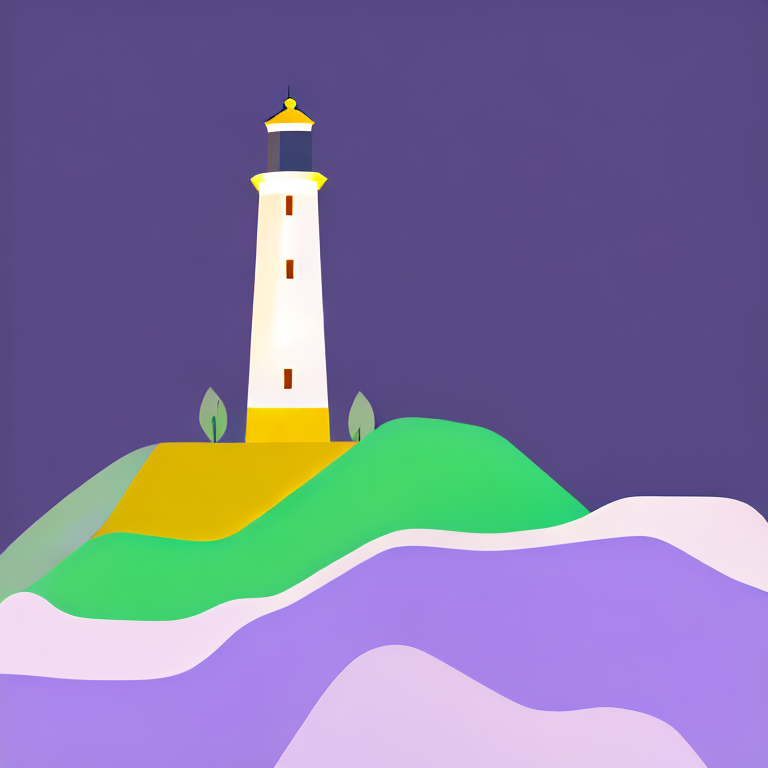

In [14]:
# 以下のデモンストレーションで使用するプロンプト関連の変数をCFGから初期化

prompt_prefix_demo = CFG.model_prompt_prefix
prompt_suffix_demo = CFG.model_prompt_suffix
negative_prompt_demo = CFG.model_negative_prompt

#学習データから1つのサンプルを取得して、その説明文を表示
r = train_df.iloc[2] # 例として3番目のデータを使用

description = r.description
print(f"画像の説明文: {description}")


#上記の説明文と接頭辞・接尾辞を組み合わせてプロンプトを作成

prompt = f'{prompt_prefix_demo} {description} {prompt_suffix_demo}'
print(f"生成用プロンプト: {prompt}")


#作成したプロンプトとネガティブプロンプトを使って画像を生成
#generate_bitmap関数はCFGからデフォルトの推論ステップ数とガイダンススケールを使用

image = generate_bitmap(prompt, negative_prompt=negative_prompt_demo)
image # 生成された画像を表示 (Jupyter環境)

In [15]:
# 生成されたビットマップ画像のスコアを計算

bitmap_scores = bitmap_score_instance(r.multiple_choice_qa, image, random_seed=CFG.random_seed)
print(f"ビットマップ画像のスコア: {bitmap_scores}")

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


ビットマップ画像のスコア: {'competition_score': 0.8207604566654404, 'vqa_score': 0.9726225152145883, 'ocr_score': 1.0, 'aesthetic_score': 0.5052242755889893}


## 3.画像からSVGへの変換

### 画像 -> SVGへ変換するための様々な工夫
このセクションでは、生成されたビットマップ画像をSVG形式に変換する処理を実装します。

提出するSVGにはファイルサイズ制限があるため、単純にビットマップ画像をSVGに変換するだけでなく、ファイルサイズを削減する工夫を施します。

主な処理の流れは以下の通りです：
1. 色の量子化: 画像の色を量子化（k-means法）して、主要な色のみを保持することで画像の色数を減らします。
2. 輪郭抽出: 量子化された画像から、各色の領域の輪郭を検出します。
3. 輪郭の単純化: 検出された輪郭をポリゴンで近似し、頂点数を減らしてSVGファイルのサイズを削減します。
4. 特徴の階層化と選択: 輪郭（ポリゴン）を面積や位置などの重要度でソートし、SVGのファイルサイズ制限内でできるだけ多くの情報を含むようにポリゴンを選択・単純化します。
5. 画像のリサイズ：必要に応じて画像をリサイズします。
6. SVG生成: 選択されたポリゴンをSVG要素として記述し、SVGファイルを構築します。

In [16]:
#| export

# 16進数カラーコードを短縮表現に変換する関数
# 例: #FF00AA -> #F0A (R,G,Bがそれぞれ17の倍数の場合)
def compress_hex_color(hex_color):
    """16進数のカラーコードを可能な限り短い表現に変換します（例: #aabbcc -> #abc）。"""
    r, g, b = int(hex_color[1:3], 16), int(hex_color[3:5], 16), int(hex_color[5:7], 16)
    if r % 17 == 0 and g % 17 == 0 and b % 17 == 0:
        # 各RGB値が17の倍数の場合、1桁の16進数で表現可能
        return f'#{r//17:x}{g//17:x}{b//17:x}'
    return hex_color

# 画像から階層的な特徴（色ごとのポリゴン）を抽出する関数
def extract_features_by_scale(img_np, num_colors=16): # num_colorsはbitmap_to_svg_layeredから渡される
    """
    画像から色ごとの輪郭を抽出し、重要度に基づいてソートされた特徴のリストを返します。
    Args:
        img_np (np.ndarray): 入力画像 (NumPy配列)。
        num_colors (int): 量子化する色の数。
    Returns:
        list: 抽出されたポリゴンの特徴 (座標、色、面積、重要度など) のリスト。
    """
    # 画像がグレースケールの場合、RGBに変換
    if len(img_np.shape) == 3 and img_np.shape[2] > 1:
        img_rgb = img_np
    else:
        img_rgb = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)

    height, width = img_rgb.shape[:2]

    # k-means法による色の量子化
    pixels = img_rgb.reshape(-1, 3).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2) # k-meansの停止条件

    # k-meansのseed設定
    if CFG.use_random_k_means_seed:
        current_seed = random.randint(0, 2**31 - 1)
    else:
        current_seed = CFG.k_means_seed if hasattr(CFG, 'k_means_seed') else 0
    cv2.setRNGSeed(current_seed)

    _, labels, centers = cv2.kmeans(pixels, num_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    palette = centers.astype(np.uint8) # 量子化された色のパレット
    quantized_image = palette[labels.flatten()].reshape(img_rgb.shape) # 量子化された画像

    hierarchical_features = [] # 抽出された特徴を格納するリスト

    # 色の出現頻度に基づいてソート
    unique_labels, counts = np.unique(labels, return_counts=True)
    sorted_indices = np.argsort(-counts) # 降順ソート
    sorted_colors = [palette[i] for i in sorted_indices]

    center_x, center_y = width / 2, height / 2 # 画像中心

    # ソートされた各色について輪郭を抽出
    for color_val in sorted_colors:
        # 特定の色に対応するマスクを作成
        color_mask = cv2.inRange(quantized_image, color_val, color_val)
        
        # マスクから輪郭を検出
        contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=cv2.contourArea, reverse=True) # 面積でソート

        hex_color_str = compress_hex_color(f'#{color_val[0]:02x}{color_val[1]:02x}{color_val[2]:02x}')

        color_specific_features = []
        for contour in contours:
            area = cv2.contourArea(contour)
            # 小さすぎる輪郭は無視 (CFGから閾値を取得)
            if area < CFG.svg_contour_min_area:
                continue

            # 輪郭のモーメントを計算して中心座標を取得
            m = cv2.moments(contour)
            if m["m00"] == 0: continue # 面積0の輪郭はスキップ
            cx = int(m["m10"] / m["m00"])
            cy = int(m["m01"] / m["m00"])

            # 画像中心からの距離 (正規化)
            dist_from_center = np.sqrt(((cx - center_x) / width)**2 + ((cy - center_y) / height)**2)

            # 輪郭を単純化 (Douglas-Peuckerアルゴリズム)
            epsilon = CFG.svg_approx_poly_dp_epsilon_factor * cv2.arcLength(contour, True) # epsilon係数はCFGから取得
            approx_poly = cv2.approxPolyDP(contour, epsilon, True)

            # ポリゴンの頂点座標を文字列に変換 (小数点以下1桁)
            points_str = " ".join([f"{pt[0][0]:.1f},{pt[0][1]:.1f}" for pt in approx_poly])

            # 特徴の重要度を計算 (面積、中心からの近さ、複雑さの逆数)
            importance = (area * (1 - dist_from_center) * (1 / (len(approx_poly) + 1e-6))) # ゼロ除算を避ける

            color_specific_features.append({
                'points': points_str,
                'color': hex_color_str,
                'area': area,
                'importance': importance,
                'point_count': len(approx_poly),
                'original_contour': approx_poly # 適応的単純化のために元の輪郭を保存
            })
        
        # この色に関する特徴を重要度でソート
        color_specific_features.sort(key=lambda x: x['importance'], reverse=True)
        hierarchical_features.extend(color_specific_features)

    # 全ての特徴を重要度で最終ソート
    hierarchical_features.sort(key=lambda x: x['importance'], reverse=True)
    return hierarchical_features

# ポリゴンを単純化する関数
def simplify_polygon(points_str, simplification_level):
    """
    ポリゴンの頂点座標文字列を、指定されたレベルに応じて単純化します。
    Args:
        points_str (str): スペース区切りの "x,y" 形式の頂点座標文字列。
        simplification_level (int): 単純化のレベル (0:変更なし, 1:小数点1桁, 2:整数, 3:頂点削減)。
    Returns:
        str: 単純化された頂点座標文字列。
    """
    if simplification_level == 0:
        return points_str

    points_list = points_str.split()

    if simplification_level == 1: # レベル1: 小数点以下1桁に丸める
        return " ".join([f"{float(p.split(',')[0]):.1f},{float(p.split(',')[1]):.1f}" for p in points_list])
    
    if simplification_level == 2: # レベル2: 整数に丸める
        return " ".join([f"{float(p.split(',')[0]):.0f},{float(p.split(',')[1]):.0f}" for p in points_list])

    if simplification_level == 3: # レベル3: 頂点数を減らす（1つおきに点を保持、最低3点は確保）
        if len(points_list) <= 4:
            # 点が4つ以下の場合、整数に丸めるだけ
            return " ".join([f"{float(p.split(',')[0]):.0f},{float(p.split(',')[1]):.0f}" for p in points_list])
        else:
            # 約半分の点を保持するが、少なくとも3点は維持する
            step = min(2, len(points_list) // 3) # 3点未満にならないよう調整
            reduced_points = [points_list[i] for i in range(0, len(points_list), step)]
            if len(reduced_points) < 3 and len(points_list) >=3: # 元が3点以上なら最低3点
                 reduced_points = points_list[:3]
            if points_list[-1] not in reduced_points and reduced_points: # 最後の点は必ず含める
                reduced_points.append(points_list[-1])
            return " ".join([f"{float(p.split(',')[0]):.0f},{float(p.split(',')[1]):.0f}" for p in reduced_points])
    
    return points_str # 未定義のレベルの場合は変更なし

# ビットマップ画像を階層化された特徴抽出を用いてSVGに変換する関数
def bitmap_to_svg_layered(image, 
                         max_size_bytes=CFG.svg_max_size_bytes - 350, #OCR対策のデコイの処理でおよそ350文字追加されるため、減算 
                         resize=CFG.svg_resize, 
                         target_size=CFG.svg_target_size,
                         adaptive_fill=CFG.svg_adaptive_fill, 
                         num_colors=CFG.svg_num_colors_default):
    """
    ビットマップ画像をSVG形式に変換します。ファイルサイズ制限内で最適化を行います。
    Args:
        image (PIL.Image): 入力画像。
        max_size_bytes (int): SVGの最大許容バイト数。
        resize (bool): 処理前に画像をリサイズするかどうか。
        target_size (tuple): リサイズする場合のターゲットサイズ (幅, 高さ)。
        adaptive_fill (bool): 利用可能なスペースを適応的に埋めるかどうか。
        num_colors (int, optional): 量子化する色の数。
    Returns:
        str: SVG形式の文字列。
    """
    
    original_size = image.size
    if resize:
        image = image.resize(target_size, Image.LANCZOS) # LANCZOSでリサンプル
    
    img_np_array = np.array(image)
    current_height, current_width = img_np_array.shape[:2]

    # 背景色を画像の平均色で決定 (RGB画像の場合)
    if len(img_np_array.shape) == 3 and img_np_array.shape[2] == 3:
        avg_bg_color_val = np.mean(img_np_array, axis=(0,1)).astype(int)
        bg_hex_color_str = compress_hex_color(f'#{avg_bg_color_val[0]:02x}{avg_bg_color_val[1]:02x}{avg_bg_color_val[2]:02x}')
    else: # グレースケール等の場合は白背景
        bg_hex_color_str = '#fff' 

    # SVGヘッダーと背景。viewBoxは処理後の画像の寸法、width/heightは元の画像の寸法
    orig_width, orig_height = original_size
    svg_header_str = f'<svg xmlns="http://www.w3.org/2000/svg" width="{orig_width}" height="{orig_height}" viewBox="0 0 {current_width} {current_height}">\n'
    svg_bg_rect_str = f'<rect width="{current_width}" height="{current_height}" fill="{bg_hex_color_str}"/>\n'
    svg_base_content = svg_header_str + svg_bg_rect_str
    svg_footer_str = '</svg>'

    base_content_size = len((svg_base_content + svg_footer_str).encode('utf-8'))
    available_bytes_for_features = max_size_bytes - base_content_size

    # 画像から特徴（ポリゴン）を抽出
    extracted_features = extract_features_by_scale(img_np_array, num_colors=num_colors)

    # 適応的フィルを使用しない場合: 単純に特徴を追加していく
    if not adaptive_fill:
        current_svg_content = svg_base_content
        for feature_item in extracted_features:
            feature_svg_element = f'<polygon points="{feature_item["points"]}" fill="{feature_item["color"]}" />\n'
            if len((current_svg_content + feature_svg_element + svg_footer_str).encode('utf-8')) > max_size_bytes:
                break # サイズ制限を超えたら終了
            current_svg_content += feature_svg_element
        current_svg_content += svg_footer_str
        return current_svg_content

    # 適応的フィルを使用する場合: 2パスアプローチで単純化レベルを調整しながら特徴を追加
    # 各特徴について、異なる単純化レベルでのSVG要素サイズを事前計算
    feature_element_sizes = []
    for feature_item in extracted_features:
        feature_element_sizes.append({
            'original': len(f'<polygon points="{feature_item["points"]}" fill="{feature_item["color"]}" />\n'.encode('utf-8')),
            'level1': len(f'<polygon points="{simplify_polygon(feature_item["points"], 1)}" fill="{feature_item["color"]}" />\n'.encode('utf-8')),
            'level2': len(f'<polygon points="{simplify_polygon(feature_item["points"], 2)}" fill="{feature_item["color"]}" />\n'.encode('utf-8')),
            'level3': len(f'<polygon points="{simplify_polygon(feature_item["points"], 3)}" fill="{feature_item["color"]}" />\n'.encode('utf-8'))
        })

    current_svg_content = svg_base_content
    bytes_used_so_far = base_content_size
    added_feature_indices = set()

    # パス1: 最も重要な特徴を元の品質で追加
    for i, feature_item in enumerate(extracted_features):
        feature_svg_element = f'<polygon points="{feature_item["points"]}" fill="{feature_item["color"]}" />\n'
        current_feature_size = feature_element_sizes[i]['original']
        if bytes_used_so_far + current_feature_size <= max_size_bytes:
            current_svg_content += feature_svg_element
            bytes_used_so_far += current_feature_size
            added_feature_indices.add(i)

    # パス2: 残りの特徴を単純化レベルを上げながら追加
    for simpl_level in range(1, 4): # 単純化レベル 1, 2, 3
        for i, feature_item in enumerate(extracted_features):
            if i in added_feature_indices: continue # 既に追加済みならスキップ

            current_feature_size = feature_element_sizes[i][f'level{simpl_level}']
            if bytes_used_so_far + current_feature_size <= max_size_bytes:
                simplified_points = simplify_polygon(feature_item["points"], simpl_level)
                feature_svg_element = f'<polygon points="{simplified_points}" fill="{feature_item["color"]}" />\n'
                current_svg_content += feature_svg_element
                bytes_used_so_far += current_feature_size
                added_feature_indices.add(i)
    
    current_svg_content += svg_footer_str

    # 最終的なサイズチェック。万が一超過していたら、背景のみのSVGを返す
    final_svg_size = len(current_svg_content.encode('utf-8'))
    if final_svg_size > max_size_bytes:
        return f'<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 {current_width} {current_height}"><rect width="{current_width}" height="{current_height}" fill="{bg_hex_color_str}"/></svg>'
    
    # print(f"SVG size: {final_svg_size} bytes, Utilization: {(final_svg_size / max_size_bytes) * 100:.2f}%")
    return current_svg_content

### 3.2 デモ
- 作成されたSVGを表示し、そのスコアを計算する。
- 2.2のデモを動かした後に実行する必要があります。

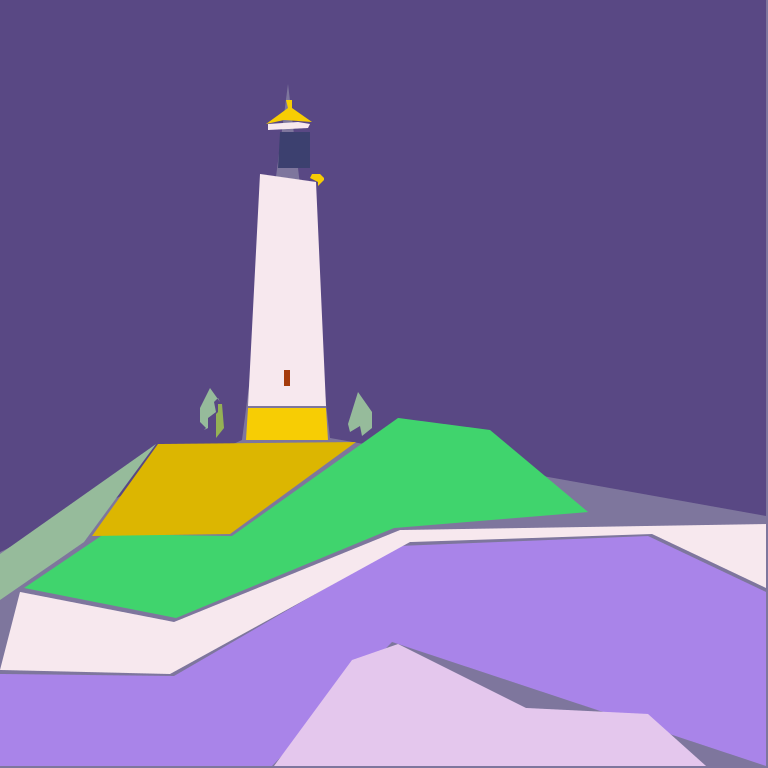

In [17]:
# bitmap_to_svg_layered関数はCFGからデフォルト引数を使用
svg_content = bitmap_to_svg_layered(image)
SVG(svg_content) # 生成されたSVGを表示 (Jupyter環境)

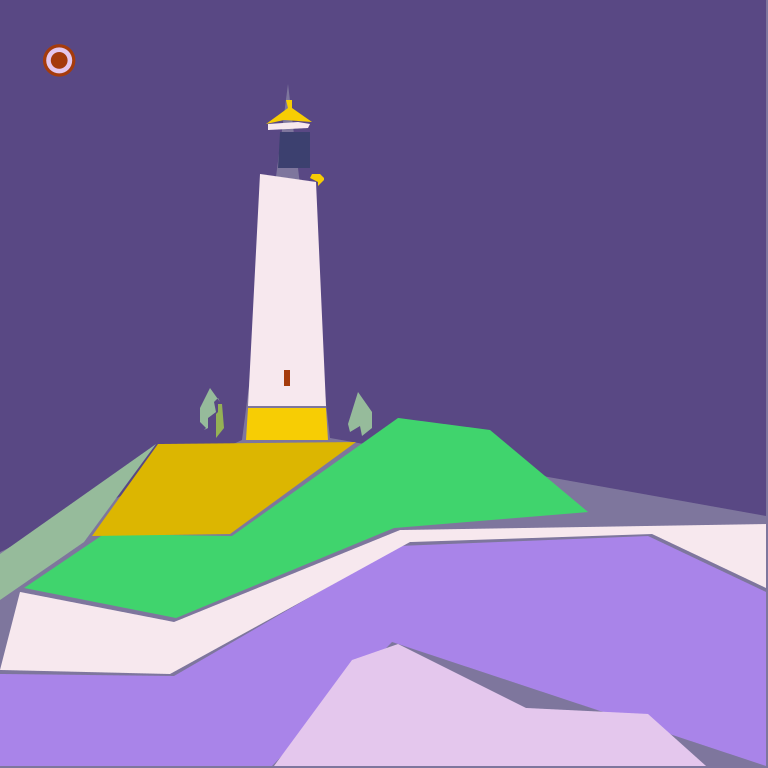

In [18]:
# OCRデコイ追加後を表示
svg_content = add_ocr_decoy_svg(svg_content)
SVG(svg_content) # 生成されたSVGを表示 (Jupyter環境)

In [19]:
#生成されたSVGのスコアを計算
#random_seedはCFGから取得

svg_scores = score_instance(r.multiple_choice_qa, svg_content, random_seed=CFG.random_seed)
print(f"SVG画像のスコア: {svg_scores}")

#最適化メトリクス：美的スコアとOCRスコアを取得
aesthetic_score_val, ocr_score_val = get_aes_and_ocr_score(svg_content)
print(f"美的スコア: {aesthetic_score_val}, OCRスコア: {ocr_score_val}")

SVG画像のスコア: {'competition_score': 0.7346522397896149, 'vqa_score': 0.8564064304366602, 'ocr_score': 1.0, 'aesthetic_score': 0.46832666397094724}
美的スコア: 0.46832666397094724, OCRスコア: 1.0


## 4.提出パッケージの実装

### 4.1 パッケージのModelクラスを実装
- **`Model`クラス**:
    - このクラスは、画像生成からSVG変換、そしてスコア最適化までの一連の処理をカプセル化します。
    - `__init__`: プロンプトの接頭辞・接尾辞、Stable Diffusionの推論ステップ数・ガイダンススケール、最適化のための試行回数などを`CFG`から設定します。
    - `gen_bitmap`: `Model`クラス固有のパラメータ設定でビットマップ画像を生成します。
    - `predict`メソッドは、与えられた説明文から最適なSVGを生成することを目指します。
        - `predict_impl`:
            1. 説明文からビットマップ画像を生成 (`gen_bitmap`)。
            2. 生成したビットマップをSVGに変換 (`bitmap_to_svg_layered`)。
            3. SVGの美的スコアとOCRスコアを取得 (`get_aes_and_ocr_score`)。
            4. 美的スコアとOCRスコアの**積**を最終スコアとして計算。
            5. 上記1～4を`model_num_attempt`回繰り返し、最終スコアが最も高かったSVGとその元ビットマップを返します。
        - `predict`: `predict_impl`を呼び出し、最終的に最適と判断されたSVG文字列のみを返します。

In [20]:
#| export

class Model:
    def __init__(self):
        # CFGからモデルのデフォルト設定を初期化
        self.default_svg = CFG.model_default_svg
        self.prompt_prefix = CFG.model_prompt_prefix
        self.prompt_suffix = CFG.model_prompt_suffix
        self.negative_prompt = CFG.model_negative_prompt

        self.seed = CFG.random_seed
        self.num_inference_steps = CFG.model_num_inference_steps # 画像生成時の推論ステップ数
        self.guidance_scale = CFG.model_guidance_scale           # 画像生成時のガイダンススケール
        self.num_attempt = CFG.model_num_attempt                 # 最適なSVGを見つけるための試行回数

    # 説明文に基づいてビットマップ画像を生成する内部メソッド
    def gen_bitmap(self, description_text):
        # クラス固有のプロンプト接頭辞・接尾辞を使用
        full_prompt = f'{self.prompt_prefix} {description_text} {self.prompt_suffix}'
        # クラス固有の推論ステップ数とガイダンススケールでビットマップを生成
        bitmap_image = generate_bitmap(full_prompt, self.negative_prompt, 
                                      self.num_inference_steps, self.guidance_scale, self.seed)
        return bitmap_image

    # プロンプト（説明文）からSVGを生成する内部実装メソッド
    # 複数回試行し、美的スコアとOCRスコアの積が最も高いものを選択
    def predict_impl(self, description_prompt: str) -> tuple[str, Image.Image | None]:
        """
        説明文プロンプトから最適なSVG文字列と対応するビットマップ画像を生成します。
        Args:
            description_prompt (str): 画像の内容を表す説明文。
        Returns:
            tuple: (最適なSVG文字列, 対応するビットマップ画像)
        """
        best_combined_score = 0.0
        best_svg_output = None
        best_generated_image = None
        
        for _ in range(self.num_attempt): # 設定された試行回数だけ繰り返す
            # 1. ビットマップ画像を生成
            current_bitmap = self.gen_bitmap(description_prompt)
            
            # 2. ビットマップをSVGに変換 (bitmap_to_svg_layeredはCFG由来のデフォルトパラメータを使用)
            current_svg = bitmap_to_svg_layered(current_bitmap)

            # 3. SVGコードに変換後、評価前にOCRデコイを追加(文字と認識されるオブジェクト)
            current_svg = add_ocr_decoy_svg(current_svg)
            
            # 4. SVGの美的スコアとOCRスコアを取得 (get_aes_and_ocr_scoreはCFG由来のデフォルトパラメータを使用)
            aes_score, ocr_s = get_aes_and_ocr_score(current_svg)
            
            # 5. スコアを評価 (美的スコア * OCRスコア)
            current_score = aes_score * ocr_s
            
            if current_score >= best_combined_score: # より良いスコアなら更新
                best_combined_score = current_score
                best_svg_output = current_svg
                best_generated_image = current_bitmap
                print(f'スコア更新: {best_combined_score:.4f} (AES: {aes_score:.4f}, OCR: {ocr_s:.4f})')

        if best_svg_output is None: # 一度も有効なSVGが生成されなかった場合
            best_svg_output = self.default_svg # デフォルトSVGを返す
            best_generated_image = None # この場合、対応するビットマップはない

        return best_svg_output, best_generated_image

    # プロンプト（説明文）からSVGを生成する公開メソッド
    def predict(self, description_prompt: str) -> str:
        """
        説明文プロンプトから最適なSVG文字列を生成します。
        Args:
            description_prompt (str): 画像の内容を表す説明文。
        Returns:
            str: 最適なSVG文字列。
        """
        svg_result, _ = self.predict_impl(description_prompt) # ビットマップは返さない
        return svg_result

### 4.2 デモ
作成されたSVGを表示し、そのスコアを計算する。

画像の説明文: a lighthouse overlooking the ocean


  0%|          | 0/25 [00:00<?, ?it/s]

スコア更新: 0.4602 (AES: 0.4602, OCR: 1.0000)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Model生成SVGのスコア: {'competition_score': 0.7441105545045639, 'vqa_score': 0.8798369171425868, 'ocr_score': 1.0, 'aesthetic_score': 0.46016478538513184}


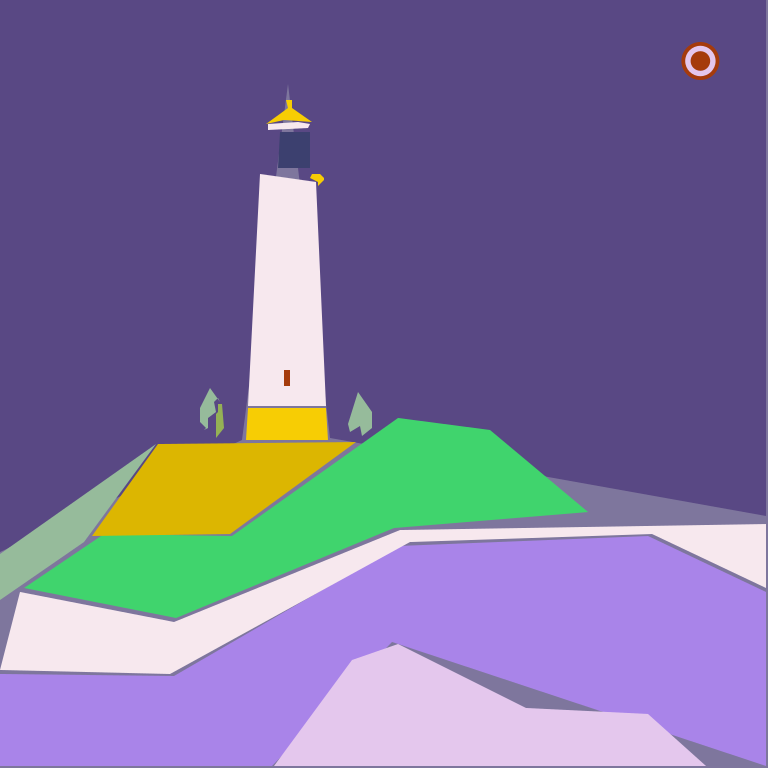

In [21]:
# Modelクラスのインスタンスを作成
model = Model()

#学習データから1つのサンプルを取得して、その説明文を表示
r = train_df.iloc[2] # 例として3番目のデータを使用

description = r.description
print(f"画像の説明文: {description}")

#Modelクラスのpredictメソッドを使用してSVGを生成

svg_output_from_model = model.predict(description)

#SVGのスコアを計算
model_svg_scores = score_instance(r.multiple_choice_qa, svg_output_from_model, random_seed=CFG.random_seed)# `r`変数は以前のセルで定義されたサンプルデータ。random_seedはCFGから取得
print(f"Model生成SVGのスコア: {model_svg_scores}")

SVG(svg_output_from_model) # 作成されたSVGを表示

## 5.学習データセットを用いた検証
- 学習データセット全体に対して作成したパッケージを適用し、生成されたSVGの平均スコアを計算します。
- これにより、リーダーボード（LB）でのスコアをある程度予測することができます。
- 各サンプルについて、元のビットマップ画像のスコアと、生成されたSVGのスコアの両方を評価し比較します。

In [22]:
# from tqdm.auto import tqdm #提出パッケージには含まれないため、ここでimport
# tqdm.pandas() # プログレスバーを表示

# # Modelクラスのインスタンスを作成
# model = Model()

# # Jupyter Notebookでmatplotlibのプロットをインライン表示するためのマジックコマンド
# %matplotlib inline


# #学習データセットの各説明文に対してmodel.predict_implを実行し、結果 (SVGとビットマップ) を保存
# train_df['raw_res'] = train_df.description.progress_apply(model.predict_impl)

In [23]:
# # 'raw_res' カラムからSVG文字列とビットマップ画像をそれぞれ別のカラムに展開

# train_df['svg'] = train_df.raw_res.apply(lambda x: x[0])
# train_df['bitmap'] = train_df.raw_res.apply(lambda x: x[1])

# # 各ビットマップ画像のスコアを計算
# # progress_applyで処理の進捗を表示
# # random_seedはCFGから取得

# train_df['bitmap_score'] = train_df.progress_apply(
#     lambda r: bitmap_score_instance(r.multiple_choice_qa, r.bitmap, random_seed=CFG.random_seed) if r.bitmap else None, # ビットマップが存在しない場合はNone
#     axis=1,
# )


# # 各SVG画像のスコアを計算
# # progress_applyで処理の進捗を表示
# # random_seedはCFGから取得

# train_df['svg_score'] = train_df.progress_apply(
#     lambda r: score_instance(r.multiple_choice_qa, r.svg, random_seed=CFG.random_seed),
#     axis=1,
# )

### 各画像のプロンプト、質問、回答候補、回答一覧

### 0: a purple forest at dusk (夕暮れの紫色の森)

1. **What is the main setting of the image?** (画像の主な舞台は何ですか？)
   - Choices: ["beach", "desert", "forest", "mountain"]
   - Answer: ["forest"] (森)

2. **Is there anything purple in the image?** (画像に紫色のものはありますか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

3. **What time of day is suggested in the image?** (画像は一日のどの時間帯を示唆していますか？)
   - Choices: ["dawn", "dusk", "midday", "midnight"]
   - Answer: ["dusk"] (夕暮れ)

4. **What color is prominently featured in the image?** (画像で目立つ色は何ですか？)
   - Choices: ["green", "orange", "purple", "white"]
   - Answer: ["purple"] (紫色)

### 1: a gray wool coat with faux fur collar (フェイクファーの襟がある灰色のウールコート)

1. **What color is the coat?** (コートの色は何ですか？)
   - Choices: ["blue", "brown", "gray", "red"]
   - Answer: ["gray"] (灰色)

2. **What part of the coat has faux fur?** (コートのどの部分にフェイクファーがありますか？)
   - Choices: ["collar", "hem", "pockets", "sleeves"]
   - Answer: ["collar"] (襟)

3. **Is the coat purple?** (コートは紫色ですか？)
   - Choices: ["no", "yes"]
   - Answer: ["no"] (いいえ)

4. **What material is the coat made of?** (コートは何の素材でできていますか？)
   - Choices: ["cotton", "leather", "silk", "wool"]
   - Answer: ["wool"] (ウール)

### 2: a lighthouse overlooking the ocean (海を見下ろす灯台)

1. **Is there an ocean visible in the image?** (画像に海が見えますか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

2. **What is the spatial relationship between the lighthouse and the ocean?** (灯台と海の空間的関係は何ですか？)
   - Choices: ["inside", "next to", "overlooking", "under"]
   - Answer: ["overlooking"] (見下ろす)

3. **Is there a desert in the image?** (画像に砂漠はありますか？)
   - Choices: ["no", "yes"]
   - Answer: ["no"] (いいえ)

4. **Is the lighthouse located under the ocean?** (灯台は海の下にありますか？)
   - Choices: ["no", "yes"]
   - Answer: ["no"] (いいえ)

### 3: burgundy pants with patch pockets (パッチポケット付きのバーガンディ色のパンツ)

1. **Are the pants yellow?** (パンツは黄色ですか？)
   - Choices: ["no", "yes"]
   - Answer: ["no"] (いいえ)

2. **Do the pants have patch pockets?** (パンツにはパッチポケットがありますか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

3. **Are the pants burgundy?** (パンツはバーガンディ色ですか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

4. **What item of clothing is depicted?** (どの衣類が描かれていますか？)
   - Choices: ["dress", "pants", "shirt", "skirt"]
   - Answer: ["pants"] (パンツ)

### 4: corduroy overalls (コーデュロイのオーバーオール)

1. **What material is the item?** (アイテムの素材は何ですか？)
   - Choices: ["corduroy", "denim", "leather", "silk"]
   - Answer: ["corduroy"] (コーデュロイ)

2. **Is a hat depicted?** (帽子が描かれていますか？)
   - Choices: ["no", "yes"]
   - Answer: ["no"] (いいえ)

3. **Is the item made of corduroy?** (アイテムはコーデュロイ製ですか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

4. **What type of clothing is shown?** (どのタイプの衣類が表示されていますか？)
   - Choices: ["a dress", "a skirt", "a suit", "overalls"]
   - Answer: ["overalls"] (オーバーオール)

### 5: a purple scarf with tassel trim (タッセルの装飾がある紫色のスカーフ)

1. **Is there any purple item present in the image?** (画像に紫色のアイテムはありますか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

2. **Is a scarf depicted?** (スカーフが描かれていますか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

3. **What kind of trim does the scarf have?** (スカーフにはどのような装飾がありますか？)
   - Choices: ["beaded", "fringe", "lace", "tassel"]
   - Answer: ["tassel"] (タッセル)

4. **What color is the scarf?** (スカーフの色は何ですか？)
   - Choices: ["green", "orange", "purple", "white"]
   - Answer: ["purple"] (紫色)

### 6: a green lagoon under the sky (空の下の緑色の礁湖)

1. **Is the lagoon depicted as green?** (礁湖は緑色として描かれていますか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

2. **Is there a lagoon present in the image?** (画像に礁湖はありますか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

3. **What is above the lagoon?** (礁湖の上には何がありますか？)
   - Choices: ["ceiling", "roof", "sky", "trees"]
   - Answer: ["sky"] (空)

4. **What body of water is depicted in the image?** (画像にはどの水域が描かれていますか？)
   - Choices: ["lagoon", "mountain", "ocean", "river"]
   - Answer: ["lagoon"] (礁湖)

### 7: chaotic grid of rectangles (四角形の混沌としたグリッド)

1. **Is the grid's arrangement chaotic?** (グリッドの配置は混沌としていますか？)
   - Choices: ["no", "yes"] 
   - Answer: ["yes"] (はい)

2. **Are the shapes primarily ovals?** (形状は主に楕円形ですか？)
   - Choices: ["no", "yes"]
   - Answer: ["no"] (いいえ)

3. **Is there a single large circle present?** (大きな円が1つありますか？)
   - Choices: ["no", "yes"]
   - Answer: ["no"] (いいえ)

4. **Are the primary shapes rectangles?** (主な形状は四角形ですか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

### 8: bronze cone with spiraling purple pyramids (螺旋状の紫色のピラミッドがある青銅色の円錐)

1. **Is the cone made of a bronze-like material?** (円錐は青銅のような材質でできていますか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

2. **Are the purple objects pyramid-shaped?** (紫色のオブジェクトはピラミッド形ですか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

3. **What object is at the center of the spiral?** (渦巻きの中心にあるオブジェクトは何ですか？)
   - Choices: ["cone", "cube", "pyramid", "sphere"]
   - Answer: ["cone"] (円錐)

4. **What objects are spiraling around the cone?** (円錐の周りを螺旋状に回っているオブジェクトは何ですか？)
   - Choices: ["cubes", "cylinders", "pyramids", "spheres"]
   - Answer: ["pyramids"] (ピラミッド)

### 9: magenta trapezoids on translucent silver sheet (半透明の銀色のシート上のマゼンタ色の台形)

1. **Is the color silver present in the image?** (画像に銀色は存在しますか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

2. **Which word describes the silver sheet's ability to let light through?** (銀色のシートの光を通す能力を表す言葉はどれですか？)
   - Choices: ["opaque", "reflective", "solid", "translucent"]
   - Answer: ["translucent"] (半透明)

3. **Are the trapezoids layered on something?** (台形は何かの上に重ねられていますか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

4. **What shape are the magenta objects?** (マゼンタ色のオブジェクトはどんな形ですか？)
   - Choices: ["circles", "stars", "trapezoids", "triangles"]
   - Answer: ["trapezoids"] (台形)

### 10: snowy plain (雪に覆われた平原)

1. **What covers the plain?** (平原を覆っているのは何ですか？)
   - Choices: ["grass", "sand", "snow", "water"]
   - Answer: ["snow"] (雪)

2. **What is the main geographical feature depicted?** (描かれている主な地理的特徴は何ですか？)
   - Choices: ["forest", "mountain", "ocean", "plain"]
   - Answer: ["plain"] (平原)

3. **Is the plain covered in lava?** (平原は溶岩で覆われていますか？)
   - Choices: ["no", "yes"]
   - Answer: ["no"] (いいえ)

4. **Is the plain snowy?** (平原は雪に覆われていますか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

### 11: black and white checkered pants (黒と白のチェック柄のパンツ)

1. **What is the other color in the checkered pattern besides black?** (チェック柄の黒以外の色は何ですか？)
   - Choices: ["orange", "pink", "white", "yellow"]
   - Answer: ["white"] (白)

2. **Is the item of clothing a pair of pants?** (衣類はパンツですか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

3. **Is brown part of the pattern?** (茶色はパターンの一部ですか？)
   - Choices: ["no", "yes"]
   - Answer: ["no"] (いいえ)

4. **What is one of the colors of the checkered pattern?** (チェック柄の色の一つは何ですか？)
   - Choices: ["black", "blue", "green", "red"]
   - Answer: ["black"] (黒)

### 12: night sky with peaks (頂上のある夜空)

1. **Is the image depicting a nighttime scene?** (画像は夜のシーンを描いていますか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

2. **Is the image depicting a daytime scene?** (画像は昼間のシーンを描いていますか？)
   - Choices: ["no", "yes"]
   - Answer: ["no"] (いいえ)

3. **Are there peaks visible in the image?** (画像に頂上は見えますか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

4. **Is the night sky depicted as cloudy?** (夜空は曇りとして描かれていますか？)
   - Choices: ["no", "yes"]
   - Answer: ["no"] (いいえ)

### 13: khaki triangles and crescents (カーキ色の三角形と三日月形)

1. **Are there any azure colored spirals?** (青色の渦巻きはありますか？)
   - Choices: ["no", "yes"]
   - Answer: ["no"] (いいえ)

2. **Are there any crescent shapes present?** (三日月形はありますか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

3. **What color are some of the shapes?** (いくつかの形状の色は何ですか？)
   - Choices: ["black", "khaki", "orange", "white"]
   - Answer: ["khaki"] (カーキ色)

4. **What shape are some of the khaki forms?** (カーキ色の形状はどんな形ですか？)
   - Choices: ["circles", "pentagons", "squares", "triangles"]
   - Answer: ["triangles"] (三角形)

### 14: maroon and teal elements (マルーン色とティール色の要素)

1. **Are the threads colored pink?** (糸はピンク色ですか？)
   - Choices: ["no", "yes"]
   - Answer: ["no"] (いいえ)

2. **Is there a triangle interwoven with teal threads?** (ティール色の糸で織り込まれた三角形はありますか？)
   - Choices: ["no", "yes"]
   - Answer: ["no"] (いいえ)

3. **Is there anything maroon in the image?** (画像にマルーン色のものはありますか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

4. **Are there any teal elements in the image?** (画像にティール色の要素はありますか？)
   - Choices: ["no", "yes"]
   - Answer: ["yes"] (はい)

In [24]:
# # 学習データセットの各サンプルについて、ビットマップ画像とSVG画像を並べて表示し、それぞれのスコアを表示

# for r in train_df.itertuples():
#     # ビットマップのスコア詳細を取得 (存在する場合のみ)
#     if r.bitmap and r.bitmap_score:
#         b_score = r.bitmap_score.get('competition_score', 0)
#         b_vqa = r.bitmap_score.get('vqa_score', 0)
#         b_ocr = r.bitmap_score.get('ocr_score', 0)
#         b_aesthetic = r.bitmap_score.get('aesthetic_score', 0)
#     else: # ビットマップやスコアが存在しない場合
#         b_score, b_vqa, b_ocr, b_aesthetic = 0, 0, 0, 0

#     # SVGのスコア詳細を取得
#     s_score = r.svg_score.get('competition_score', 0)
#     s_vqa = r.svg_score.get('vqa_score', 0)
#     s_ocr = r.svg_score.get('ocr_score', 0)
#     s_aesthetic = r.svg_score.get('aesthetic_score', 0)

#     plt.figure(figsize=(12, 6))
#     plt.suptitle(f"prompt: {r.description}", y=0.93, fontsize=10) # yとfontsize調整

#     # ビットマップ画像表示
#     plt.subplot(1, 2, 1)
#     if r.bitmap:
#         plt.imshow(np.array(r.bitmap))
#     else: # ビットマップがない場合はテキスト表示
#         plt.text(0.5, 0.5, "No Bitmap Generated", ha='center', va='center')
#     plt.axis('off')
#     plt.title(f'bitmap: score={b_score:.2f}\nVQA={b_vqa:.2f}, OCR={b_ocr:.2f}, aes={b_aesthetic:.2f}', fontsize=9)

#     # SVG画像表示 (PNGに変換して表示)
#     plt.subplot(1, 2, 2)
#     try:
#         plt.imshow(svg_to_png(r.svg))
#     except Exception as e: # SVG変換エラーの場合
#         plt.text(0.5, 0.5, f"SVG Display Error:\n{e}", ha='center', va='center', fontsize=8)

#     plt.axis('off')
#     plt.title(f'SVG: score={s_score:.2f}\nVQA={s_vqa:.2f}, OCR={s_ocr:.2f}, aes={s_aesthetic:.2f}', fontsize=9)
    
#     plt.tight_layout(rect=[0, 0, 1, 0.9]) # suptitleとの重なりを避ける
#     plt.show()

In [25]:
# # ビットマップスコアの平均を計算して表示 (Noneを除外)

# valid_bitmap_scores = [s for s in train_df['bitmap_score'].tolist() if s is not None]
# if valid_bitmap_scores:
#     mean_bitmap_score = pd.DataFrame(valid_bitmap_scores).mean(axis=0)
#     print("平均ビットマップスコア:")
#     print(mean_bitmap_score)
# else:
#     print("有効なビットマップスコアがありません。")


# # SVGスコアの平均を計算して表示 (Noneを除外)

# valid_svg_scores = [s for s in train_df['svg_score'].tolist() if s is not None]
# if valid_svg_scores:
#     mean_svg_score = pd.DataFrame(valid_svg_scores).mean(axis=0)
#     print("平均SVGスコア:")
#     print(mean_svg_score)
# else:
#     print("有効なSVGスコアがありません。")


# # 最終的な平均コンペティションスコアを表示

# if valid_bitmap_scores:
#     print(f'ビットマップ画像の平均コンペティションスコア: {mean_bitmap_score.competition_score if "competition_score" in mean_bitmap_score else "N/A"}')
# if valid_svg_scores:
#     print(f'最終的なSVG画像の平均コンペティションスコア: {mean_svg_score.competition_score if "competition_score" in mean_svg_score else "N/A"}')